## Multiclass Classification

In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from joblib import parallel_backend
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler, label_binarize
from sklearn.feature_selection import f_classif
from sklearn.metrics import (
    balanced_accuracy_score, confusion_matrix,
    roc_auc_score, RocCurveDisplay, roc_curve, auc
)
from sklearn.model_selection   import StratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipe
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Monkey‑patch SMOTE if necessary (imbalanced‑learn < 0.13)
def _validate_data(self, X, y=None, reset=True, accept_sparse=None, **kw): return X, y
SMOTE._validate_data = _validate_data

In [3]:
# ────────────────────────────────────────────────
# 0. Constants & random seed
# ────────────────────────────────────────────────
RANDOM_STATE = 2025
CV_SPLITS    = 5
np.random.seed(RANDOM_STATE)

In [4]:
# ────────────────────────────────────────────────
# 1. Load data & pre‑saved split
# ────────────────────────────────────────────────
gene   = pd.read_csv("../X_gene_raw.csv",   index_col=0)
cpg    = pd.read_csv("../X_cpg_raw.csv",    index_col=0)
immune = pd.read_csv("../X_immune_raw.csv", index_col=0)
age    = pd.read_csv("../X_age_raw.csv",    index_col=0)

subtype_map = {"Basal":0,"LumA":1,"LumB":2}
y_cat = pd.read_csv("../multiclass_y_labels_cat.csv", index_col=0).Subtype
y     = y_cat.map(subtype_map).to_numpy()
for df in (cpg, immune, age, y_cat):
    df.index = gene.index

train_idx = np.load("../train_idx.npy")
test_idx  = np.load("../test_idx.npy")
X_ix = np.arange(len(y))[:, None]

print(f"Loaded split: {len(train_idx)} train / {len(test_idx)} test")

Loaded split: 623 train / 70 test


In [5]:
# ────────────────────────────────────────────────
# 2. Top‑K selector
# ────────────────────────────────────────────────
class TopK(BaseEstimator, TransformerMixin):
    def __init__(self, k=50, tag=""): self.k, self.tag = k, tag
    def fit(self, X, y):
        if self.k is None:
            self.keep_ = np.arange(X.shape[1])
        else:
            _, p = f_classif(X, y)
            self.keep_ = np.argsort(p)[: self.k]
        return self
    def transform(self, X): return X[:, self.keep_]

In [6]:
# ────────────────────────────────────────────────
# 3. Block & union helpers
# ────────────────────────────────────────────────
def blk(df, k, tag):
    return Pipeline([
        ("subset", FunctionTransformer(lambda ix, df=df: df.iloc[ix.ravel()].values,
                                       validate=False)),
        ("sel",    TopK(k, tag))
    ])

def make_union(names, k_gene=100, k_cpg=100):
    blocks = {
        "age"   : blk(age,    None,      "age"),
        "immune": blk(immune, None,      "immune"),
        "gene"  : blk(gene,   k_gene,    f"gene{k_gene}"),
        "cpg"   : blk(cpg,    k_cpg,     f"cpg{k_cpg}")
    }
    return FeatureUnion([(n, blocks[n]) for n in names], n_jobs=-1)

X_sets = {
    "age"        : make_union(("age",)),
    "immune"     : make_union(("immune",)),
    "gene"       : make_union(("gene",)),
    "cpg"        : make_union(("cpg",)),
    "age_immune" : make_union(("age","immune")),
    "all"        : make_union(("age","immune","gene","cpg")),
}

In [7]:
# ────────────────────────────────────────────────
# 4. Gate&Fine meta‑estimator (binary gate + 4 fine options)
# ────────────────────────────────────────────────
class GateAndFine(BaseEstimator):
    def __init__(self, gate=None, fine=None, threshold=0.50):
        self.gate, self.fine, self.threshold = gate, fine, threshold

    def get_params(self, deep=True):
        return {"gate":self.gate, "fine":self.fine, "threshold":self.threshold}

    def set_params(self, **p):
        for k,v in p.items(): setattr(self, k, v)
        return self

    def fit(self, X, y):
        y_gate = (y==0).astype(int)
        self.gate_ = clone(self.gate).fit(X, y_gate)
        mask = y!=0
        self.fine_ = clone(self.fine).fit(X[mask], y[mask]-1)
        return self

    def predict_proba(self, X):
        p0   = self.gate_.predict_proba(X)[:,1]
        mask = p0 >= self.threshold
        P    = np.zeros((len(X),3))
        P[mask,0] = 1.0
        if (~mask).any():
            pf = self.fine_.predict_proba(X[~mask])
            P[~mask,1:] = pf
        return P / P.sum(axis=1, keepdims=True)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [8]:
# define gate model
gate_model = LGBMClassifier(
    n_estimators=400, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    objective="binary", random_state=RANDOM_STATE, n_jobs=-1
)

In [9]:
# define four fine models
fine_models = {
    "XGB": XGBClassifier(
        n_estimators=300, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        objective="binary:logistic", eval_metric="logloss",
        use_label_encoder=False, random_state=RANDOM_STATE, n_jobs=-1
    ),
    "LGBM": LGBMClassifier(
        n_estimators=400, learning_rate=0.05, num_leaves=31,
        subsample=0.8, colsample_bytree=0.8,
        objective="binary", random_state=RANDOM_STATE, n_jobs=-1
    ),
    "SVM": SVC(
        kernel="rbf", C=3, gamma="scale",
        probability=True, random_state=RANDOM_STATE
    ),
    "RF": RandomForestClassifier(
        n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1
    )
}

In [10]:
# ────────────────────────────────────────────────
# 5. Recover feature names reliably
# ────────────────────────────────────────────────
orig = {"age":age, "immune":immune, "gene":gene, "cpg":cpg}
def get_feature_names(union):
    names = []
    for name, trans in union.transformer_list:
        tag = trans.named_steps["sel"].tag
        cols= orig[name].columns
        keep= cols if trans.named_steps["sel"].k is None else cols[trans.named_steps["sel"].keep_]
        names += [f"{tag}:{c}" for c in keep]
    return np.array(names)

In [11]:
# ────────────────────────────────────────────────
# 6. Confusion / ROC plot helper
# ────────────────────────────────────────────────
def plot_confusion(cm, labels, title, ax):
    im = ax.imshow(cm, cmap="Blues", vmin=0)
    ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,i,cm[i,j],ha="center",
                    color="white" if cm[i,j]>cm.max()/2 else "black")
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")


>>> age + fine=XGB
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [13:55:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 thr=0.40  CV_BA=0.482  HO_BA=0.476  AUC=0.638


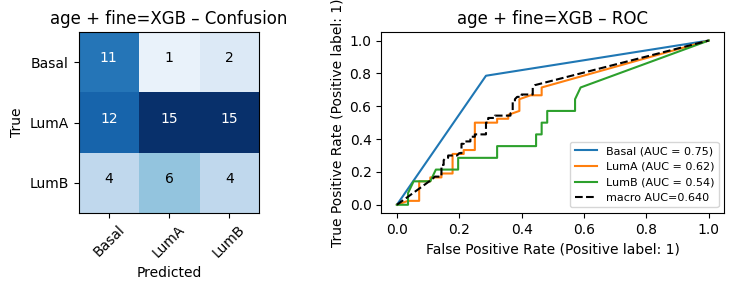


>>> age + fine=LGBM
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Number of positive: 375, number of negative: 375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, be

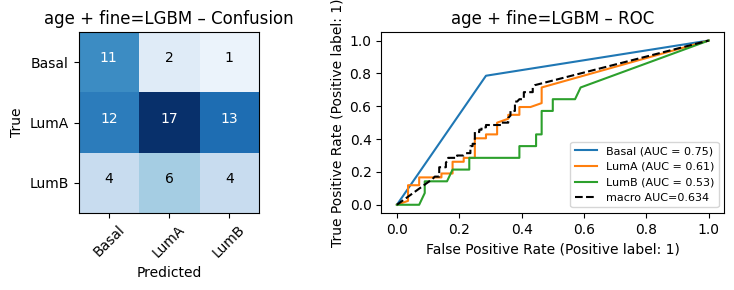


>>> age + fine=SVM
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
 thr=0.40  CV_BA=0.493  HO_BA=0.540  AUC=0.658


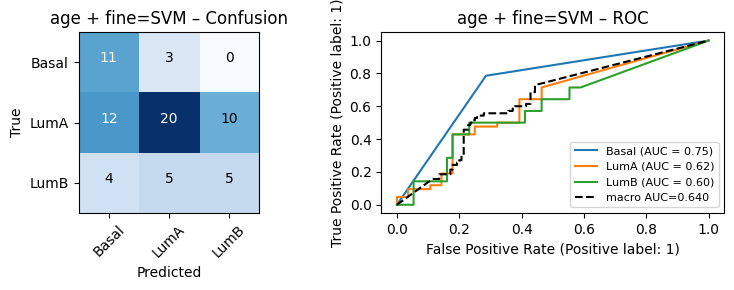


>>> age + fine=RF
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
 thr=0.40  CV_BA=0.472  HO_BA=0.468  AUC=0.635


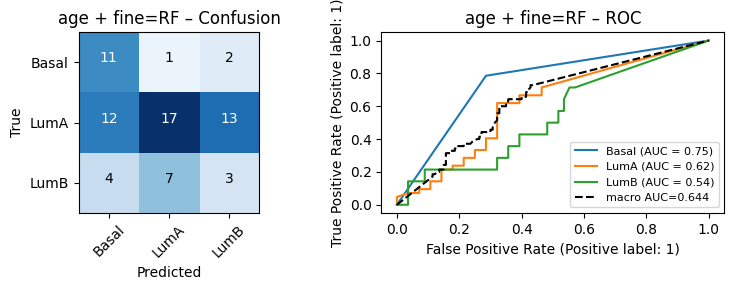


>>> immune + fine=XGB
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4183
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [13:57:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 thr=0.40  CV_BA=0.588  HO_BA=0.587  AUC=0.710


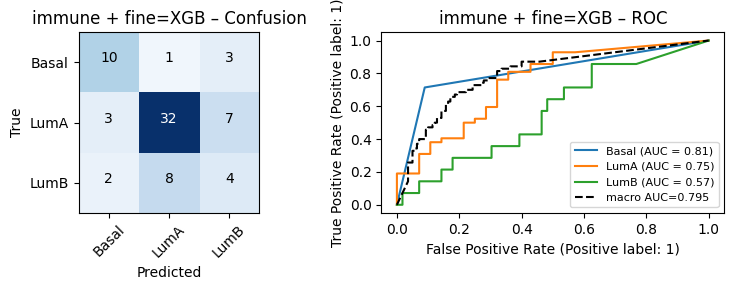


>>> immune + fine=LGBM
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4183
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

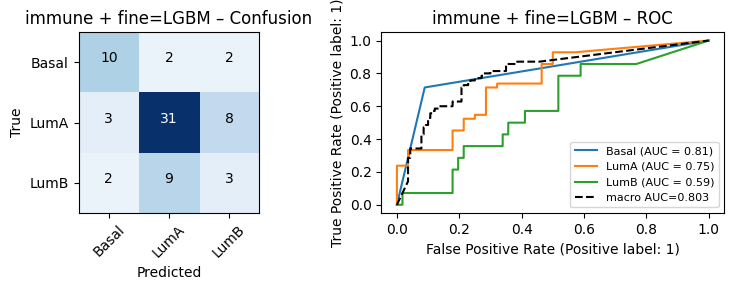


>>> immune + fine=SVM
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4183
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [ ]:
# ────────────────────────────────────────────────
# 7. Loop: each feature‐set × each fine model
# ────────────────────────────────────────────────
cv  = StratifiedKFold(CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)
lbl = ["Basal","LumA","LumB"]
results = {}

for fs_name, union in X_sets.items():
    for fm_name, fine_model in fine_models.items():
        tag = f"{fs_name} + fine={fm_name}"
        print(f"\n>>> {tag}")
        pipe = ImbPipe([
            ("feat", union),
            ("sc"  , StandardScaler()),
            ("sm"  , SMOTE(random_state=RANDOM_STATE)),
            ("clf" , GateAndFine(gate=gate_model,
                                 fine=fine_model,
                                 threshold=0.50))
        ])
        search = GridSearchCV(
            pipe,
            {"clf__threshold": np.linspace(0.40,0.60,5)},
            cv=cv, scoring="balanced_accuracy",
            n_jobs=-1, refit=True, verbose=0
        )
        # ensure no pickling errors
        with parallel_backend("threading"):
            search.fit(X_ix[train_idx], y[train_idx])

        best = search.best_estimator_
        key  = (fs_name, fm_name)
        results[key] = best

        # hold‑out evaluation
        preds = best.predict(X_ix[test_idx])
        prob  = best.predict_proba(X_ix[test_idx])
        ba    = balanced_accuracy_score(y[test_idx], preds)
        aucv  = roc_auc_score(y[test_idx], prob, multi_class="ovr")
        print(f" thr={best.named_steps['clf'].threshold:.2f}  CV_BA={search.best_score_:.3f}  HO_BA={ba:.3f}  AUC={aucv:.3f}")

        # confusion + ROC
        cm = confusion_matrix(y[test_idx], preds)
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3))
        plot_confusion(cm, lbl, f"{tag} – Confusion", ax1)

        for k, lab in enumerate(lbl):
            RocCurveDisplay.from_predictions(
                (y[test_idx]==k).astype(int), prob[:,k], name=lab, ax=ax2
            )
        fpr, tpr, _ = roc_curve(label_binarize(y[test_idx], classes=[0,1,2]).ravel(),
                                 prob.ravel())
        ax2.plot(fpr, tpr, "--", color="black", label=f"macro AUC={auc(fpr,tpr):.3f}")
        ax2.set_title(f"{tag} – ROC"); ax2.legend(fontsize=8)
        plt.tight_layout(); plt.show()

In [ ]:
# %% ================================================================
# B) SHAP analysis for one chosen model (robust to shap_values format)
# %% ================================================================
import numpy as np
import shap
import matplotlib.pyplot as plt

# 1) Map from block name → original DataFrame (for feature names)
orig = {
    "age":    age,
    "immune": immune,
    "gene":   gene,
    "cpg":    cpg
}

def get_feature_names(union):
    names = []
    for block_name, trans in union.transformer_list:
        top = trans.named_steps["sel"]
        cols = orig[block_name].columns
        keep = cols if top.k is None else cols[top.keep_]
        names += [f"{top.tag}:{c}" for c in keep]
    return np.array(names)


In [ ]:
# 2) Pick your model key, e.g. ("all","XGB")
model_key = ("all", "XGB")
best_pipe = results[model_key]

In [ ]:
# 3) Extract pipeline pieces
feat_union = best_pipe.named_steps["feat"]
scaler     = best_pipe.named_steps["sc"]
gate_m     = best_pipe.named_steps["clf"].gate_
fine_m     = best_pipe.named_steps["clf"].fine_

In [ ]:
# 4) Recover feature names
feature_names = get_feature_names(feat_union)

In [ ]:
# 5) Build processed train matrices
X_raw       = feat_union.transform(X_ix[train_idx])
X_train     = scaler.transform(X_raw)
lum_mask    = (y[train_idx] != 0)
X_train_fine= X_train[lum_mask]

In [ ]:
# 6) Compute SHAP for Gate
explainer_gate = shap.TreeExplainer(gate_m, feature_perturbation="interventional")
sv_g = explainer_gate.shap_values(X_train)
# if returned as list [neg, pos], pick the positive‐class, else take array
sv_gate = sv_g[1] if isinstance(sv_g, list) else sv_g

In [ ]:
# 7) Compute SHAP for Fine
explainer_fine = shap.TreeExplainer(fine_m, feature_perturbation="interventional")
sv_f = explainer_fine.shap_values(X_train_fine)
sv_fine = sv_f[1] if isinstance(sv_f, list) else sv_f

In [ ]:
# 8) Rank & print top‑20
def rank_shap(sv, names, top_k=20):
    mean_abs = np.abs(sv).mean(axis=0)
    idx      = np.argsort(mean_abs)[::-1][:top_k]
    return list(zip(names[idx], mean_abs[idx]))

print("🔹 Top 20 Gate features (Basal vs Luminal):")
for feat, val in rank_shap(sv_gate, feature_names):
    print(f"{feat:30s} {val:.4f}")

print("\n🔹 Top 20 Fine features (LumA vs LumB):")
for feat, val in rank_shap(sv_fine, feature_names):
    print(f"{feat:30s} {val:.4f}")

In [ ]:
# 9) SHAP summary bar plots
shap.summary_plot(sv_gate,   X_train,      feature_names=feature_names, plot_type="bar")
plt.title("Gate – mean |SHAP|");   plt.tight_layout(); plt.show()
shap.summary_plot(sv_fine,   X_train_fine, feature_names=feature_names, plot_type="bar")
plt.title("Fine – mean |SHAP|");   plt.tight_layout(); plt.show()

In [ ]:
# 1) Recompute the Top‑20 list for Gate (if you didn’t save it):
top20_gate = rank_shap(sv_gate, feature_names, top_k=20)

# 2) Pick the very top feature name:
feat = top20_gate[0][0]   # e.g. "gene100:TP53"

print("Plotting SHAP dependence for:", feat)

# 3) Dependence plot (shows how that feature’s value drives its SHAP):
import shap
shap.dependence_plot(
    feat,
    sv_gate,
    X_train,
    feature_names=feature_names,
    interaction_index=None  # or another feature name to color by interactions
)


In [ ]:
top20_fine = rank_shap(sv_fine, feature_names, top_k=20)
feat2 = top20_fine[0][0]
shap.dependence_plot(feat2, sv_fine, X_train_fine, feature_names=feature_names)
